In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/data_raw_rose.zip' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/client_rose_raw.txt' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/imposter_rose_raw.txt' './'

In [ ]:
!wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

--2021-04-06 06:48:48--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  9.00MB/s    in 13s     

2021-04-06 06:49:00 (4.85 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d "shape_predictor_68_face_landmarks.dat.bz2"

In [ ]:
!unzip data_raw_rose.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test71.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test27.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test4.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test81.jpg  
  inflating: data/imposter/Vm_NT_5s_wg_E_23_139/test43.jpg  
   creating: data/imposter/Mf_NT_5s_wg_E_10_45/
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test9.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test26.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test24.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test37.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test12.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test36.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test16.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test76.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test62.jpg  
  inflating: data/imposter/Mf_NT_5s_wg_E_10_45/test55.jpg 

In [ ]:
import cv2
import dlib
import numpy as np
import os
from imutils import paths
import pickle
import random
from scipy.stats import norm
import tqdm
INPUT_SIZE = 112


# TEst

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
img = cv2.imread('/content/data/client/G_NT_5s_g_E_11_1/test0.jpg')

In [ ]:
Y, X, C = img.shape
X, Y, C

(720, 1280, 3)

In [ ]:
dets = detector(img[...,::-1])
if dets:
  max_a = (dets[0].bottom() - dets[0].top()) * (dets[0].right() - dets[0].left())
  d = dets[0]
  if len(dets) > 1:
    for dz in dets[1:]:
      h = (dz.bottom() - dz.top()) * (dz.right() - dz.left())
      if h > max_a:
        d = dz

In [ ]:
size = [Y-d.bottom(), d.left(), d.top(), X-d.right()]
min_ = min(size)
min_

156

In [ ]:
img = cv2.rectangle(img, (d.left()-min_,d.top()-min_), (d.right()+min_,d.bottom()+min_),(255,0,0),5)

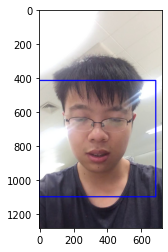

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img[...,::-1])

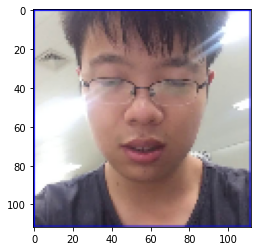

In [ ]:
test = cv2.resize(img[d.top()-min_:d.bottom()+min_,d.left()-min_:d.right()+min_,::-1], (112,112))
import matplotlib.pyplot as plt
plt.imshow(test)

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
client_dataset = []
for name in os.listdir('/content/data/client'):
    client_dataset.append(name)

In [ ]:
def create_box_rgb(img):
  Y, X, C = img.shape
  dets = detector(img)
  flag = False
  if dets:
    max_a = (dets[0].bottom() - dets[0].top()) * (dets[0].right() - dets[0].left())
    d = dets[0]
    if len(dets) > 1:
      for dz in dets[1:]:
        h = (dz.bottom() - dz.top()) * (dz.right() - dz.left())
        if h > max_a:
          d = dz
    size = [Y-d.bottom(), d.left(), d.top(), X-d.right()]
    min_ = min(size)
    return (d.top()-min_,d.bottom()+min_,d.left()-min_,d.right()+min_), flag
  else:
    flag = True
    return None, flag

In [ ]:
def crop_rgb(img, box):
  top, bottom, left, right = box
  img = img[top:bottom, left:right]
  dets = detector(img)
  flag = False
  if dets:
    try:
      temp = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
    except Exception as e:
      flag = True
    if flag:
      return None, flag
    else:
      return temp, flag
  else:
    return None, True


In [ ]:
def calculate_optical_flow(old, new):
  old = old[...,::-1]
  new = new[...,::-1]
  old_gray = cv2.cvtColor(old, cv2.COLOR_BGR2GRAY)
  new_gray = cv2.cvtColor(new, cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(old_gray, new_gray, None, 0.5, 3, 29, 3, 5, 1.2, 0)
  return flow

In [ ]:
X_5 = []
X_10 = []
X_15 = []
X_20 = []
imagePaths = list(map(lambda x: x.rstrip(),open('client_rose_raw.txt').readlines()))
for key in tqdm.tqdm(client_dataset):
    imgs = list(filter(lambda x: key in x, imagePaths))
    if len(imgs) < 20:
      print('Not valid')
    else:
      for i in range(len(imgs)):
        if i + 19 > len(imgs) - 1 :
          break
        else:
          flags = []
          old = dlib.load_rgb_image(imgs[i])
          new_5 = dlib.load_rgb_image(imgs[i+4])
          new_10 = dlib.load_rgb_image(imgs[i+9])
          new_15 = dlib.load_rgb_image(imgs[i+14])
          new_20 = dlib.load_rgb_image(imgs[i+19])
          box, e = create_box_rgb(old)
          if box is None:
            continue
          else:
            old, e = crop_rgb(old, box)
            flags.append(e)
            new_5, e = crop_rgb(new_5, box)
            flags.append(e)
            new_10, e = crop_rgb(new_10, box)
            flags.append(e)
            new_15, e = crop_rgb(new_15, box)
            flags.append(e)
            new_20, e = crop_rgb(new_20, box)
            flags.append(e)
          if True in flags:
            continue
          else:
            flow_5 = calculate_optical_flow(old, new_5)
            flow_10 = calculate_optical_flow(old, new_10)
            flow_15 = calculate_optical_flow(old, new_15)
            flow_20 = calculate_optical_flow(old, new_20)
            X_5.append(flow_5)
            X_10.append(flow_10)
            X_15.append(flow_15)
            X_20.append(flow_20)
      





  0%|          | 0/180 [00:00<?, ?it/s]


  1%|          | 1/180 [00:41<2:03:59, 41.56s/it]


  1%|          | 2/180 [01:22<2:03:00, 41.46s/it]


  2%|▏         | 3/180 [02:17<2:14:06, 45.46s/it]


  2%|▏         | 4/180 [03:25<2:32:47, 52.09s/it]


  3%|▎         | 5/180 [04:14<2:29:32, 51.27s/it]


  3%|▎         | 6/180 [05:09<2:31:50, 52.36s/it]


  4%|▍         | 7/180 [05:44<2:16:07, 47.21s/it]


  4%|▍         | 8/180 [06:21<2:06:36, 44.17s/it]


  5%|▌         | 9/180 [07:24<2:22:07, 49.87s/it]


  6%|▌         | 10/180 [08:10<2:17:47, 48.63s/it]


  6%|▌         | 11/180 [08:57<2:15:33, 48.13s/it]


  7%|▋         | 12/180 [10:09<2:35:07, 55.40s/it]


  7%|▋         | 13/180 [10:59<2:29:20, 53.66s/it]


  8%|▊         | 14/180 [11:39<2:17:06, 49.56s/it]


  8%|▊         | 15/180 [12:18<2:07:33, 46.38s/it]


  9%|▉         | 16/180 [12:56<2:00:09, 43.96s/it]


  9%|▉         | 17/180 [13:46<2:03:47, 45.57s/it]


 10%|█         | 18/180 [14:26<1:58:52, 44.03s/it]


 11%|█    

In [ ]:
X_5 = np.array(X_5)
X_10 = np.array(X_10)
X_15 = np.array(X_15)
X_20 = np.array(X_20)
X_5.shape, X_10.shape, X_15.shape, X_20.shape

((13416, 112, 112, 2),
 (13416, 112, 112, 2),
 (13416, 112, 112, 2),
 (13416, 112, 112, 2))

In [ ]:
with open('X_5_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_5, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_10, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_15_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_15, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_20, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_5_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_10_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_15_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_20_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
imposter_dataset = []
for name in os.listdir('/content/data/imposter'):
    imposter_dataset.append(name)

In [ ]:
X_5_imposter = []
X_10_imposter = []
X_15_imposter = []
X_20_imposter = []
imagePaths = list(map(lambda x: x.rstrip(),open('imposter_rose_raw.txt').readlines()))
for key in tqdm.tqdm(imposter_dataset):
    imgs = list(filter(lambda x: key in x, imagePaths))
    if len(imgs) < 20:
      print('Not valid')
    else:
      for i in range(len(imgs)):
        if i + 19 > len(imgs) - 1 :
          break
        else:
          flags = []
          old = dlib.load_rgb_image(imgs[i])
          new_5 = dlib.load_rgb_image(imgs[i+4])
          new_10 = dlib.load_rgb_image(imgs[i+9])
          new_15 = dlib.load_rgb_image(imgs[i+14])
          new_20 = dlib.load_rgb_image(imgs[i+19])
          box, e = create_box_rgb(old)
          if box is None:
            continue
          else:
            old, e = crop_rgb(old, box)
            flags.append(e)
            new_5, e = crop_rgb(new_5, box)
            flags.append(e)
            new_10, e = crop_rgb(new_10, box)
            flags.append(e)
            new_15, e = crop_rgb(new_15, box)
            flags.append(e)
            new_20, e = crop_rgb(new_20, box)
            flags.append(e)
          if True in flags:
            continue
          else:
            flow_5 = calculate_optical_flow(old, new_5)
            flow_10 = calculate_optical_flow(old, new_10)
            flow_15 = calculate_optical_flow(old, new_15)
            flow_20 = calculate_optical_flow(old, new_20)
            X_5_imposter.append(flow_5)
            X_10_imposter.append(flow_10)
            X_15_imposter.append(flow_15)
            X_20_imposter.append(flow_20)




  0%|          | 0/360 [00:00<?, ?it/s]


  0%|          | 1/360 [00:41<4:11:07, 41.97s/it]


  1%|          | 2/360 [01:21<4:06:44, 41.35s/it]


  1%|          | 3/360 [01:58<3:57:31, 39.92s/it]


  1%|          | 4/360 [02:34<3:49:52, 38.74s/it]


  1%|▏         | 5/360 [03:07<3:39:26, 37.09s/it]


  2%|▏         | 6/360 [03:39<3:28:36, 35.36s/it]


  2%|▏         | 7/360 [04:14<3:28:31, 35.44s/it]


  2%|▏         | 8/360 [04:50<3:28:09, 35.48s/it]


  2%|▎         | 9/360 [05:29<3:34:12, 36.62s/it]


  3%|▎         | 10/360 [06:13<3:46:11, 38.78s/it]


  3%|▎         | 11/360 [06:49<3:41:33, 38.09s/it]


  3%|▎         | 12/360 [07:20<3:28:28, 35.94s/it]


  4%|▎         | 13/360 [08:04<3:41:03, 38.22s/it]


  4%|▍         | 14/360 [08:45<3:45:15, 39.06s/it]


  4%|▍         | 15/360 [09:21<3:40:12, 38.30s/it]


  4%|▍         | 16/360 [09:52<3:26:43, 36.06s/it]


  5%|▍         | 17/360 [10:15<3:04:02, 32.19s/it]


  5%|▌         | 18/360 [11:10<3:41:23, 38.84s/it]


  5%|▌    

In [ ]:
X_5_imposter = np.array(X_5_imposter)
X_10_imposter = np.array(X_10_imposter)
X_15_imposter = np.array(X_15_imposter)
X_20_imposter = np.array(X_20_imposter)
X_5_imposter.shape, X_10_imposter.shape, X_15_imposter.shape, X_20_imposter.shape

((18168, 112, 112, 2),
 (18168, 112, 112, 2),
 (18168, 112, 112, 2),
 (18168, 112, 112, 2))

In [ ]:
with open('X_5_imposter_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_5_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_10_imposter_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_10_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_15_imposter_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_15_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('X_20_imposter_rose_raw_true_2.pickle', 'wb') as handle:
  pickle.dump(X_20_imposter, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'X_5_imposter_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_10_imposter_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_15_imposter_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp 'X_20_imposter_rose_raw_true_2.pickle' '/content/drive/MyDrive/RoseYoutu/'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_5_rose_raw_true_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_10_rose_raw_true_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_15_rose_raw_true_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_20_rose_raw_true_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_5_imposter_rose_raw_true_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_10_imposter_rose_raw_true_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_15_imposter_rose_raw_true_2.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_20_imposter_rose_raw_true_2.pickle' './'

In [ ]:
with open('X_5_imposter_rose_raw_true_2.pickle', 'rb') as handle:
  X_5_imposter = pickle.load(handle)

In [ ]:
with open('X_10_imposter_rose_raw_true_2.pickle', 'rb') as handle:
  X_10_imposter = pickle.load(handle)

In [ ]:
with open('X_15_imposter_rose_raw_true_2.pickle', 'rb') as handle:
  X_15_imposter = pickle.load(handle)

In [ ]:
with open('X_20_imposter_rose_raw_true_2.pickle', 'rb') as handle:
  X_20_imposter = pickle.load(handle)

In [ ]:
with open('X_5_rose_raw_true_2.pickle', 'rb') as handle:
  X_5 = pickle.load(handle)

In [ ]:
with open('X_10_rose_raw_true_2.pickle', 'rb') as handle:
  X_10 = pickle.load(handle)

In [ ]:
with open('X_15_rose_raw_true_2.pickle', 'rb') as handle:
  X_15 = pickle.load(handle)

In [ ]:
with open('X_20_rose_raw_true_2.pickle', 'rb') as handle:
  X_20 = pickle.load(handle)

In [ ]:
y = np.array([0]*X_5.shape[0] + [1]*X_5_imposter.shape[0])

In [ ]:
X_5_total = np.vstack((X_5, X_5_imposter))
del X_5
del X_5_imposter
X_10_total = np.vstack((X_10, X_10_imposter))
del X_10
del X_10_imposter
X_15_total = np.vstack((X_15, X_15_imposter))
del X_15
del X_15_imposter
X_20_total = np.vstack((X_20, X_20_imposter))
del X_20
del X_20_imposter

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train_5,  X_test_5, y_train_5, y_test_5 = train_test_split(X_5_total, y, test_size = 0.2, random_state=42)
del X_5_total
X_train_10,  X_test_10, y_train_10, y_test_10 = train_test_split(X_10_total, y, test_size = 0.2, random_state=42)
del X_10_total
X_train_15,  X_test_15, y_train_15, y_test_15 = train_test_split(X_15_total, y, test_size = 0.2, random_state=42)
del X_15_total
X_train_20,  X_test_20, y_train_20, y_test_20 = train_test_split(X_20_total, y, test_size = 0.2, random_state=42)
del X_20_total

In [ ]:
False in (y_train_10 == y_train_15)

False

In [ ]:
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# SIMPLE NET

In [ ]:
def simple_net(n_channels = 2):
  simple_net = tf.keras.Sequential()
  simple_net.add(tf.keras.layers.Input((112, 112, n_channels)))
  simple_net.add(tf.keras.layers.Conv2D(16, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(32, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(64, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(128, (3, 3)))
  simple_net.add(tf.keras.layers.BatchNormalization())
  simple_net.add(tf.keras.layers.Activation('relu'))
  simple_net.add(tf.keras.layers.MaxPooling2D())
  simple_net.add(tf.keras.layers.Conv2D(256, (5, 5)))
  simple_net.add(tf.keras.layers.Flatten())
  simple_net.add(tf.keras.layers.Reshape((-1,1)))
  return simple_net

In [ ]:
simple_net_5 = simple_net()
simple_net_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 110, 110, 16)      304       
_________________________________________________________________
batch_normalization_16 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
activation_16 (Activation)   (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_17 (Batc (None, 53, 53, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 53, 53, 32)       

In [ ]:
simple_net_10 = simple_net()
simple_net_10.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 110, 110, 16)      304       
_________________________________________________________________
batch_normalization_20 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
activation_20 (Activation)   (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_21 (Batc (None, 53, 53, 32)        128       
_________________________________________________________________
activation_21 (Activation)   (None, 53, 53, 32)       

In [ ]:
simple_net_15 = simple_net()
simple_net_15.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 110, 110, 16)      304       
_________________________________________________________________
batch_normalization_24 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
activation_24 (Activation)   (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_25 (Batc (None, 53, 53, 32)        128       
_________________________________________________________________
activation_25 (Activation)   (None, 53, 53, 32)       

In [ ]:
simple_net_20 = simple_net()
simple_net_20.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 110, 110, 16)      304       
_________________________________________________________________
batch_normalization_28 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
activation_28 (Activation)   (None, 110, 110, 16)      0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 53, 53, 32)        4640      
_________________________________________________________________
batch_normalization_29 (Batc (None, 53, 53, 32)        128       
_________________________________________________________________
activation_29 (Activation)   (None, 53, 53, 32)       

In [ ]:
def min_pool2d(x):
    min_x = -K.pool2d(-x, pool_size=(2, 2), strides=(2, 2))
    return min_x
def min_pool2d_output_shape(input_shape):
    shape = list(input_shape)
    shape[1] /= 2
    shape[2] /= 2
    return tuple(shape)

In [ ]:
concat = tf.keras.layers.Concatenate(axis=-1)([simple_net_5.output, simple_net_10.output, simple_net_15.output, simple_net_20.output])
# concat.shape
reshap = tf.keras.layers.Reshape((256, 4, 1))(concat)
reshap.shape
max = tf.keras.layers.MaxPooling2D()(reshap)
ave = tf.keras.layers.AveragePooling2D()(reshap)
min = tf.keras.layers.Lambda(min_pool2d, output_shape=min_pool2d_output_shape)(reshap)

In [ ]:
max_flatten = tf.keras.layers.Flatten()(max)
ave_flatten = tf.keras.layers.Flatten()(ave)
min_flatten = tf.keras.layers.Flatten()(min)

In [ ]:
concat2 = tf.keras.layers.Concatenate(axis=1)([max_flatten, ave_flatten, min_flatten])
concat2.shape

TensorShape([None, 768])

In [ ]:
sig = tf.keras.layers.Dense(1, activation='sigmoid')(concat2)

In [ ]:
model = tf.keras.Model([simple_net_5.input, simple_net_10.input, simple_net_15.input, simple_net_20.input], sig)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 112, 112, 2) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 112, 112, 2) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 112, 112, 2) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 112, 112, 2) 0                                            
____________________________________________________________________________________________

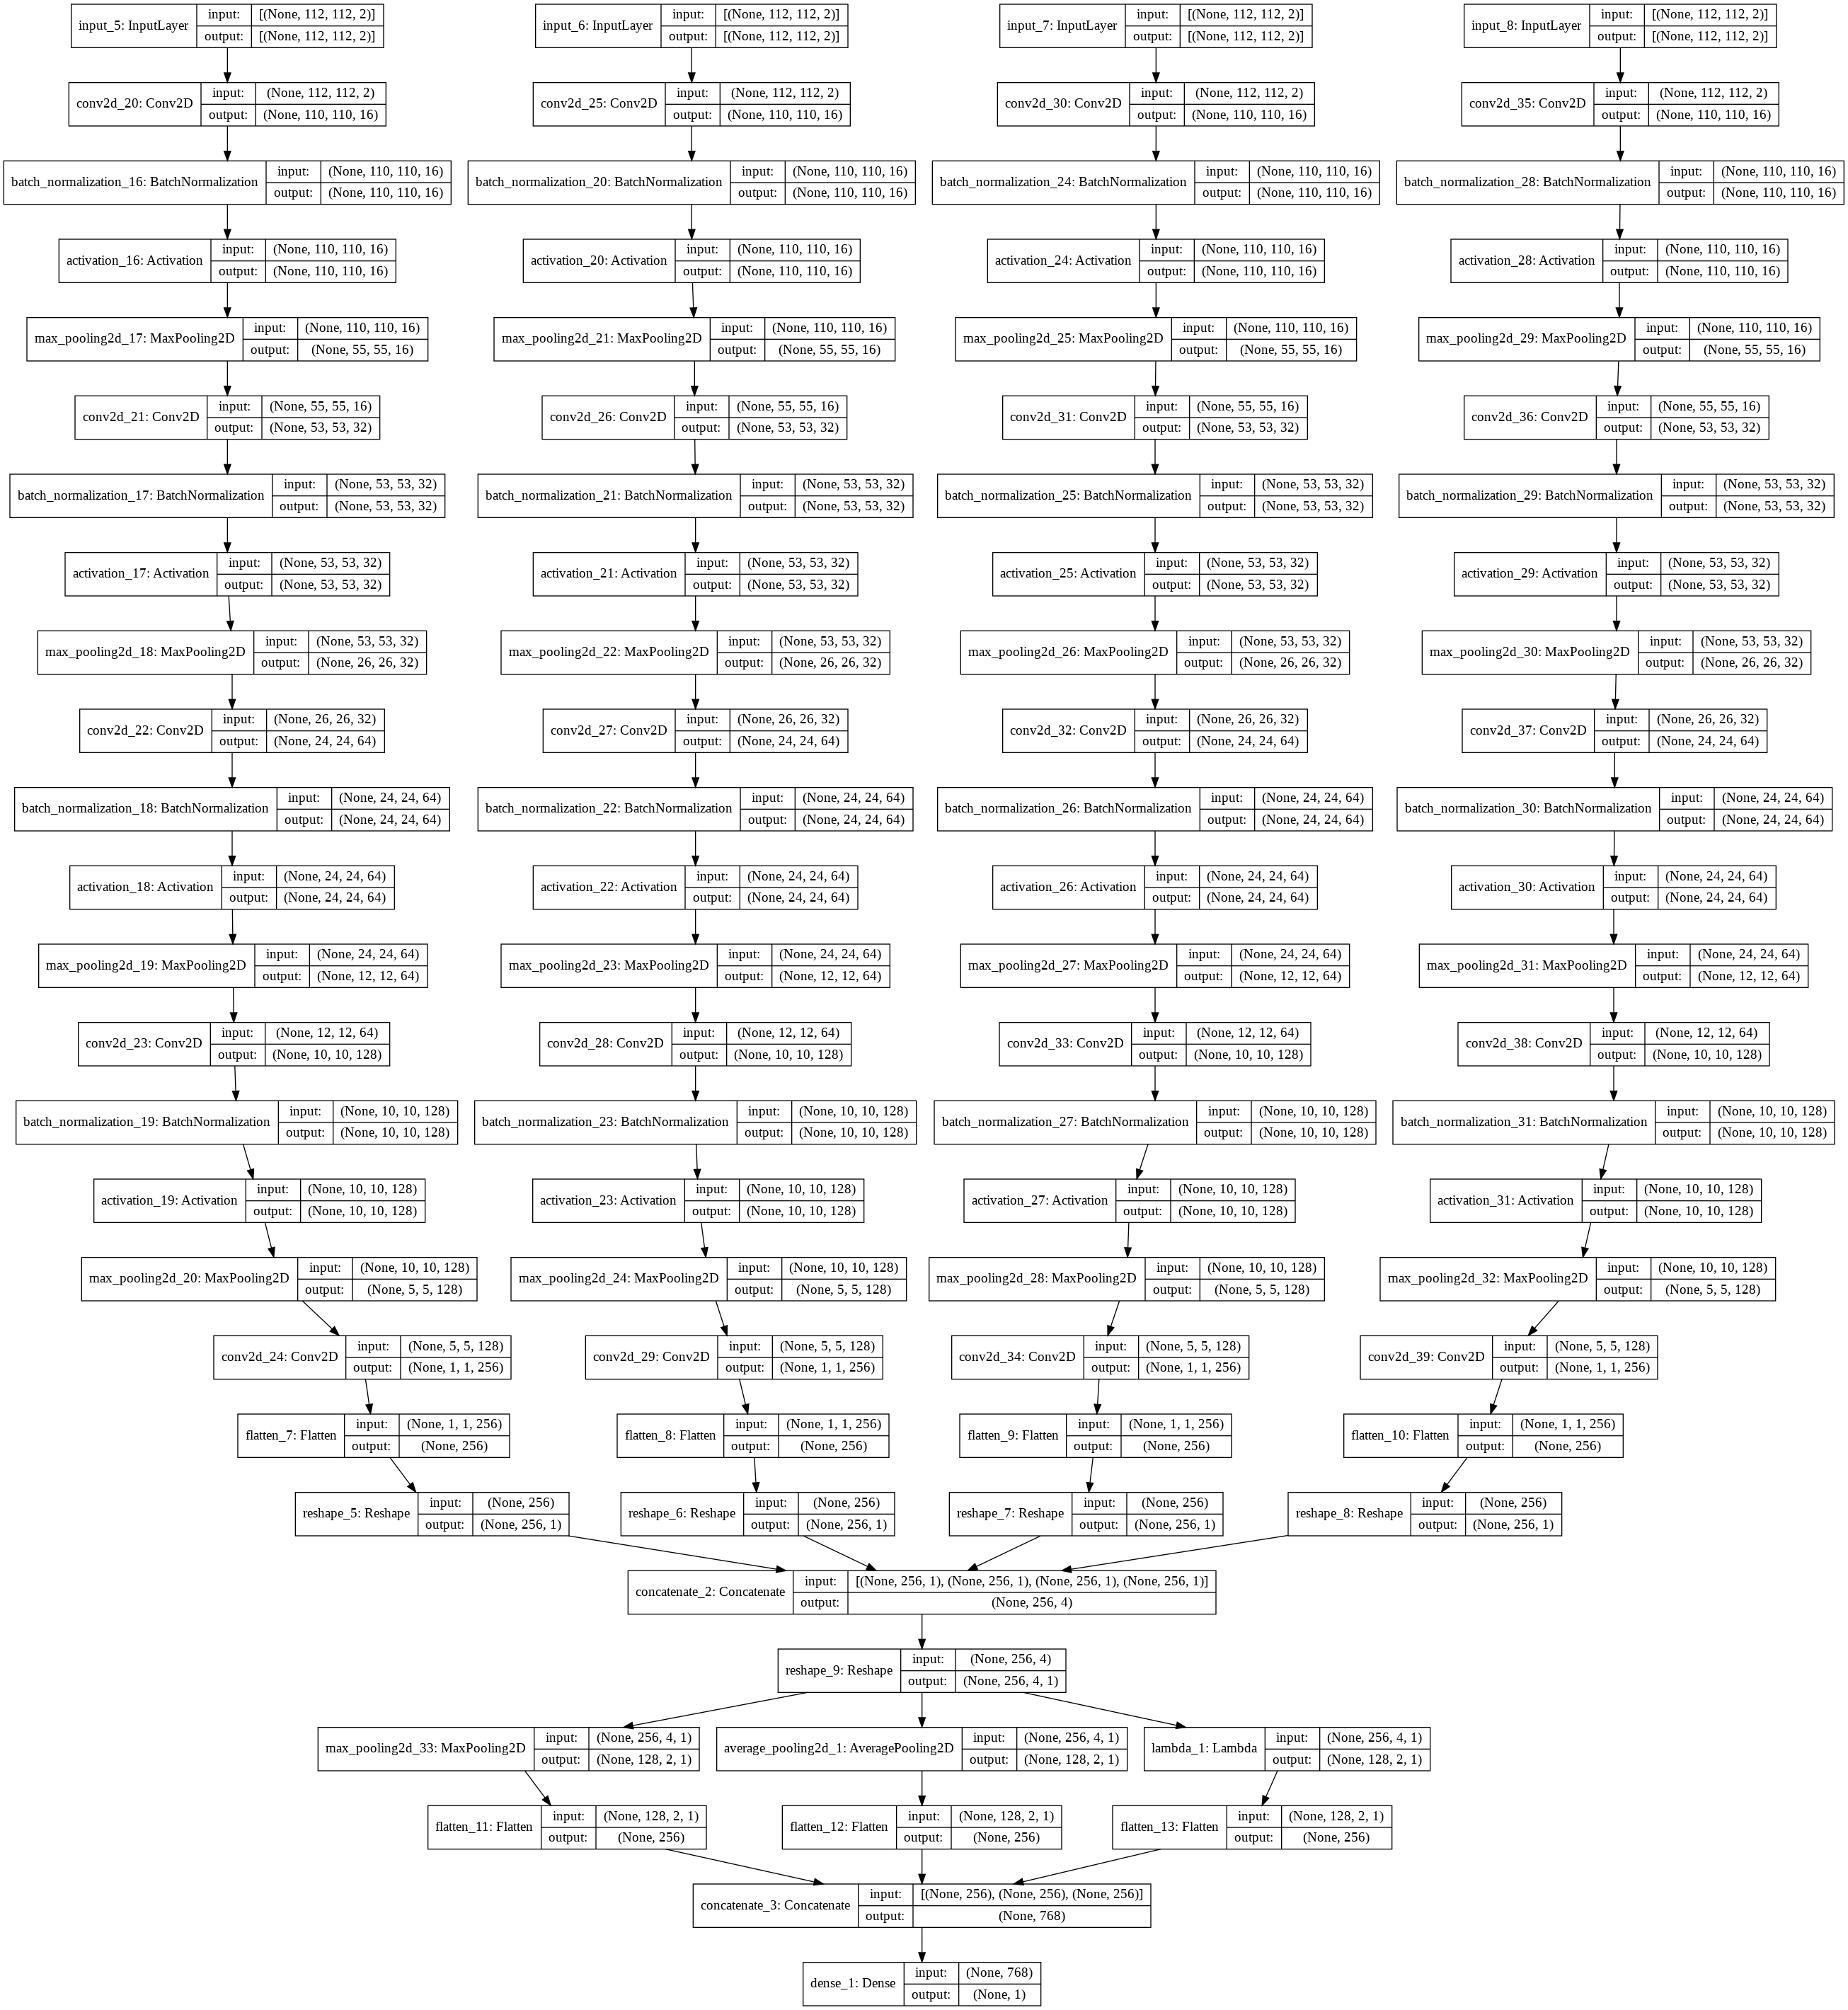

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
INIT_LR = 1e-3
BS = 8
EPOCHS = 15

In [ ]:
# opt = Adam(lr=INIT_LR)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
H = model.fit([X_train_5, X_train_10, X_train_15, X_train_20], y_train_5, batch_size=BS,
	validation_split=0.2,
	epochs=EPOCHS)

Epoch 1/15
2527/2527 [==============================] - 39s 15ms/step - loss: 1.3466 - accuracy: 0.5666 - val_loss: 0.6240 - val_accuracy: 0.6541
Epoch 2/15
2527/2527 [==============================] - 36s 14ms/step - loss: 0.6252 - accuracy: 0.6428 - val_loss: 0.5547 - val_accuracy: 0.7230
Epoch 3/15
2527/2527 [==============================] - 36s 14ms/step - loss: 0.5333 - accuracy: 0.7380 - val_loss: 0.4678 - val_accuracy: 0.7780
Epoch 4/15
2527/2527 [==============================] - 36s 14ms/step - loss: 0.4386 - accuracy: 0.8040 - val_loss: 0.4038 - val_accuracy: 0.8304
Epoch 5/15
2527/2527 [==============================] - 36s 14ms/step - loss: 0.3603 - accuracy: 0.8412 - val_loss: 0.3724 - val_accuracy: 0.8478
Epoch 6/15
2527/2527 [==============================] - 36s 14ms/step - loss: 0.2787 - accuracy: 0.8876 - val_loss: 0.2635 - val_accuracy: 0.9032
Epoch 7/15
2527/2527 [==============================] - 36s 14ms/step - loss: 0.2065 - accuracy: 0.9178 - val_loss: 0.2385 -

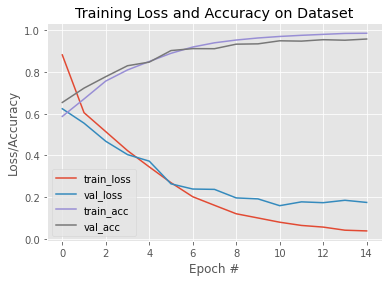

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
model.evaluate([X_test_5, X_test_10, X_test_15, X_test_20], y_test_5, batch_size=BS)

790/790 [==============================] - 5s 6ms/step - loss: 0.1641 - accuracy: 0.9573


[0.1641363948583603, 0.9572581648826599]

In [ ]:
model.save('big_model_06_04.h5')

In [ ]:
!cp 'big_model_06_04.h5' '/content/drive/MyDrive/RoseYoutu/big_model_06_04.h5'

In [ ]:
del X_test
del y_test

# Testing

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/big_model_06_04.h5' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_5_nuaa_raw_true_3.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_10_nuaa_raw_true_3.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_15_nuaa_raw_true_3.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_20_nuaa_raw_true_3.pickle' './'

In [ ]:
with open('X_5_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_5 = pickle.load(handle)

In [ ]:
with open('X_10_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_10 = pickle.load(handle)

In [ ]:
with open('X_15_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_15 = pickle.load(handle)

In [ ]:
with open('X_20_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_20 = pickle.load(handle)

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_5_imposter_nuaa_raw_true_3.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_10_imposter_nuaa_raw_true_3.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_15_imposter_nuaa_raw_true_3.pickle' './'

In [ ]:
!cp '/content/drive/MyDrive/RoseYoutu/X_20_imposter_nuaa_raw_true_3.pickle' './'

In [ ]:
with open('X_5_imposter_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_5_imposter = pickle.load(handle)

In [ ]:
with open('X_10_imposter_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_10_imposter = pickle.load(handle)

In [ ]:
with open('X_15_imposter_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_15_imposter = pickle.load(handle)

In [ ]:
with open('X_20_imposter_nuaa_raw_true_3.pickle', 'rb') as handle:
  X_20_imposter = pickle.load(handle)

In [ ]:
y = np.array([0]*X_5.shape[0] + [1]*X_5_imposter.shape[0])

In [ ]:
X_5_total = np.vstack((X_5, X_5_imposter))
del X_5
del X_5_imposter
X_10_total = np.vstack((X_10, X_10_imposter))
del X_10
del X_10_imposter
X_15_total = np.vstack((X_15, X_15_imposter))
del X_15
del X_15_imposter
X_20_total = np.vstack((X_20, X_20_imposter))
del X_20
del X_20_imposter

In [ ]:
model = tf.keras.models.load_model('big_model_06_04.h5')

In [ ]:
model.evaluate([X_5_total, X_10_total, X_15_total, X_20_total], y, batch_size=BS)

1868/1868 [==============================] - 28s 7ms/step - loss: 1.7493 - accuracy: 0.6965


[1.7493224143981934, 0.6964787840843201]

In [ ]:
X_5_total[0].shape

(112, 112, 2)

In [ ]:
y[0]

0

In [ ]:
y_pred = []
for _ in range(X_5_total.shape[0]):
  pred = model.predict([X_5_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 2), X_10_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 2), X_15_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 2), X_20_total[_].reshape(1, INPUT_SIZE, INPUT_SIZE, 2)]).flatten()[0]
  if pred > 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7882    0.6952    0.7388      9222
           1     0.5869    0.6986    0.6379      5716

    accuracy                         0.6965     14938
   macro avg     0.6875    0.6969    0.6883     14938
weighted avg     0.7111    0.6965    0.7002     14938



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
CM = confusion_matrix(y, y_pred)

In [ ]:
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

In [ ]:
APCER = FP / (TN + FP)
BPCER = FN / (TP + FN)

In [ ]:
APCER, BPCER

(0.30481457384515287, 0.30143456962911125)

In [ ]:
(APCER + BPCER) / 2

0.30312457173713203